# Graficos por sector (segun mapa)

Replica de `parroquiasEdades.ipynb` usando la misma fuente (`data/parroquiasEdades.xlsx`) pero con los sectores del mapa (`VALLES`, `UDLA`, `NORTE`, `CENTRO`, `SUR`, `NORORIENTE`, `NOROCCIDENTE`).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from routes.main import cargar_parroquias, clasificar_sectorial, normalizar_nombre

ruta_excel = "data/parroquiasEdades.xlsx"
df_raw = pd.read_excel(ruta_excel, header=None)

def encontrar_header(df):
    for i in range(min(20, len(df))):
        fila = [str(x).strip() for x in df.iloc[i].tolist()]
        if "SECTOR" in fila and "Grupo Edad" in fila:
            return i
    return None

header_idx = encontrar_header(df_raw)
if header_idx is None:
    raise ValueError("No se encontro la fila de encabezados (SECTOR, Grupo Edad).")

df = pd.read_excel(ruta_excel, header=header_idx)
df.columns = df.columns.astype(str).str.strip()

if "Parroquia" not in df.columns:
    raise ValueError(f"No existe columna 'Parroquia'. Columnas: {list(df.columns)}")

orden_grupos = df["Grupo Edad"].dropna().drop_duplicates().tolist()
orden_grupos = list(reversed(orden_grupos))
df["Grupo Edad"] = pd.Categorical(df["Grupo Edad"], categories=orden_grupos, ordered=True)

year_candidates = []
for c in df.columns:
    texto = str(c).strip()
    if texto.isdigit() and len(texto) == 4:
        year_candidates.append(c)

if not year_candidates:
    raise ValueError(f"No se encontraron columnas de anos. Columnas: {list(df.columns)}")

sector_grupo = df.groupby(["Parroquia", "Grupo Edad"], as_index=False)[year_candidates].sum()
sector_grupo = sector_grupo.rename(columns={c: str(c).strip() for c in year_candidates})

anios = [c for c in ["2001", "2010", "2022"] if c in sector_grupo.columns]
if not anios:
    raise ValueError(f"No se encontraron columnas 2001/2010/2022. Columnas: {list(sector_grupo.columns)}")

gdf = clasificar_sectorial(cargar_parroquias(scope="todas"))
lookup_sector = {
    normalizar_nombre(str(row.get("nombre", ""))): row.get("sector")
    for _, row in gdf.iterrows()
}

# Alias para variaciones de nombres presentes en la fuente de edades.
alias_sector = {
    "GUAYABAMBA": "NORORIENTE",
    "QUITO": "CENTRO",
}

sector_grupo["parroquia_norm"] = sector_grupo["Parroquia"].apply(lambda x: normalizar_nombre(str(x)))
sector_grupo["SECTOR_MAPA"] = sector_grupo["parroquia_norm"].map(lookup_sector)

sin_sector = sector_grupo["SECTOR_MAPA"].isna()
sector_grupo.loc[sin_sector, "SECTOR_MAPA"] = sector_grupo.loc[sin_sector, "parroquia_norm"].map(alias_sector)

sector_grupo = sector_grupo[sector_grupo["SECTOR_MAPA"].notna()].copy()

# Consolidar al nivel sector del mapa + grupo de edad.
sector_grupo = sector_grupo.groupby(["SECTOR_MAPA", "Grupo Edad"], as_index=False)[anios].sum()
sector_grupo = sector_grupo.rename(columns={"SECTOR_MAPA": "SECTOR"})

orden_sectores = ["VALLES", "UDLA", "NORTE", "CENTRO", "SUR", "NORORIENTE", "NOROCCIDENTE"]
sectores_disponibles = [s for s in orden_sectores if s in sector_grupo["SECTOR"].unique()]
print("Sectores disponibles:", sectores_disponibles)


C:\Users\andreidavid.flores\AppData\Local\Temp\ipykernel_48100\1627918409.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sector_grupo = df.groupby(["Parroquia", "Grupo Edad"], as_index=False)[year_candidates].sum()


Sectores disponibles: ['VALLES', 'UDLA', 'NORTE', 'CENTRO', 'SUR', 'NORORIENTE', 'NOROCCIDENTE']


C:\Users\andreidavid.flores\AppData\Local\Temp\ipykernel_48100\1627918409.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sector_grupo = sector_grupo.groupby(["SECTOR_MAPA", "Grupo Edad"], as_index=False)[anios].sum()


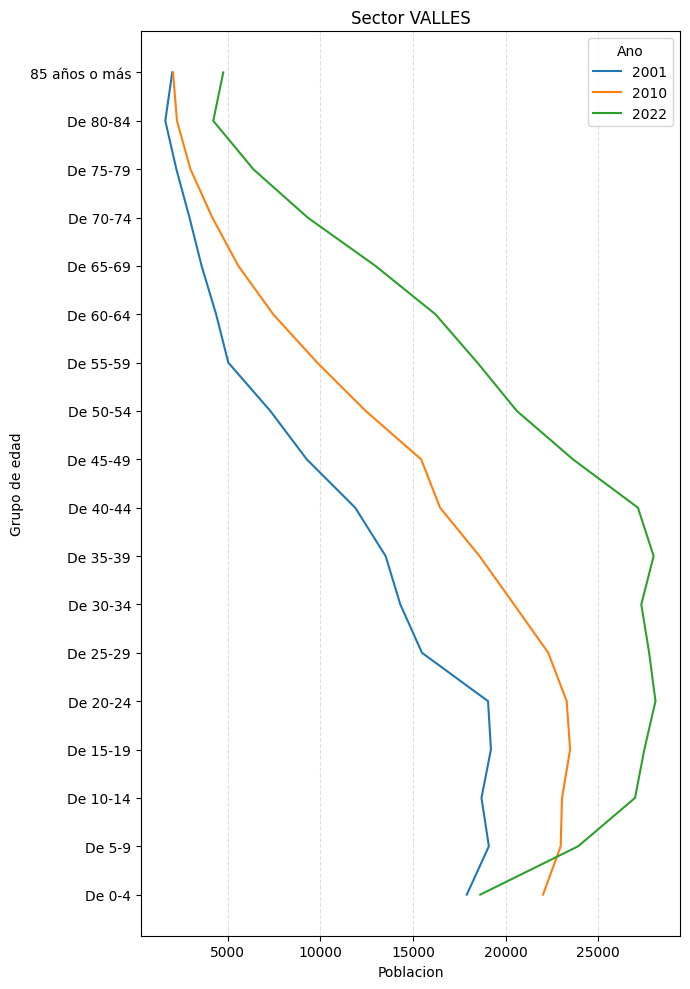

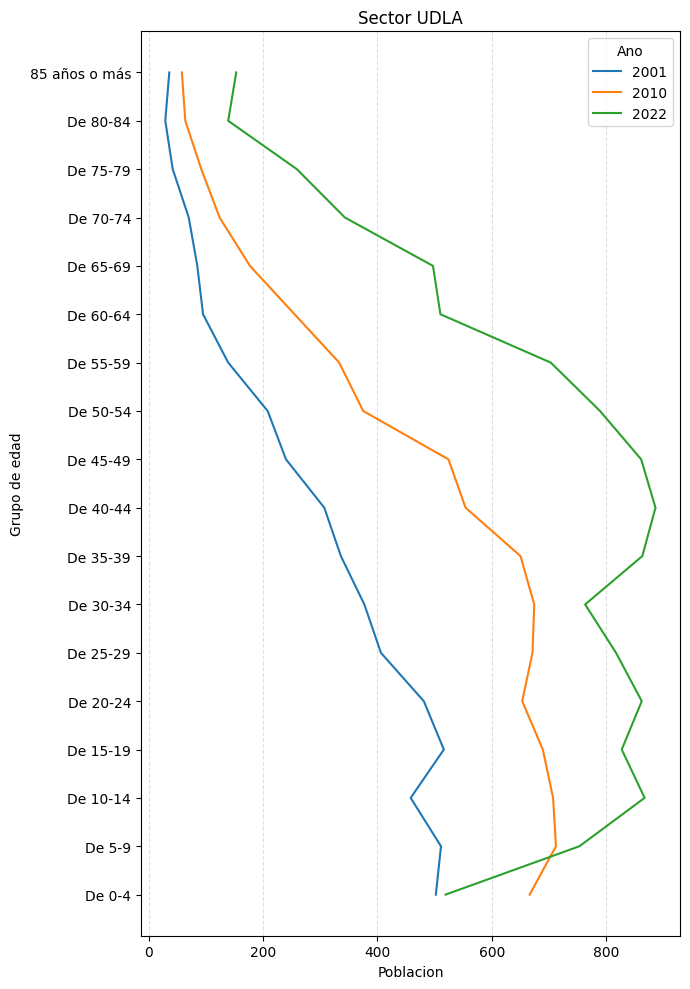

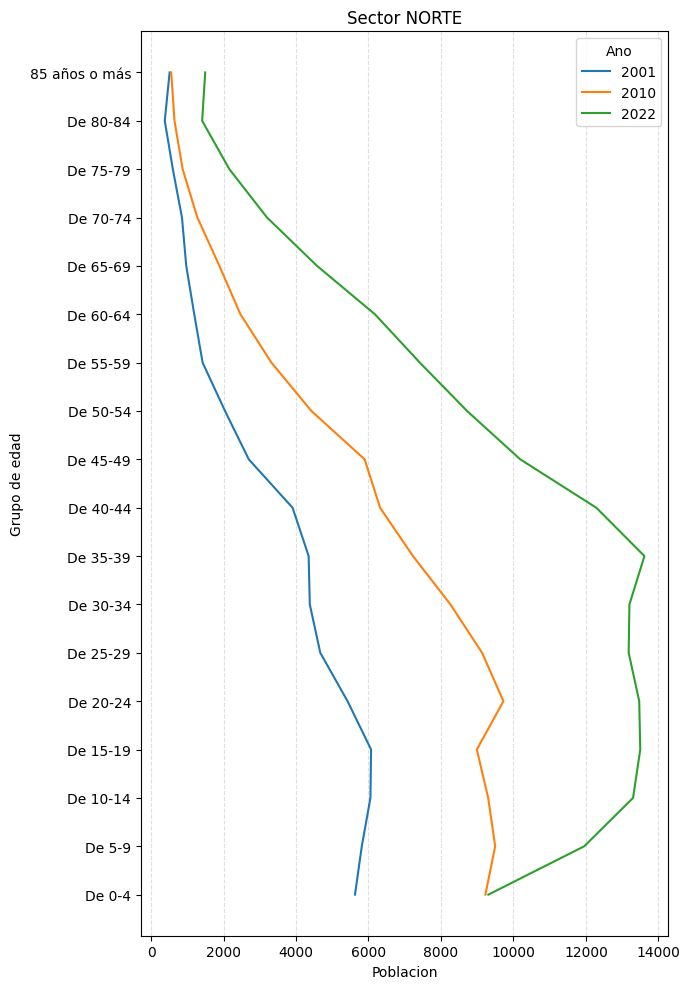

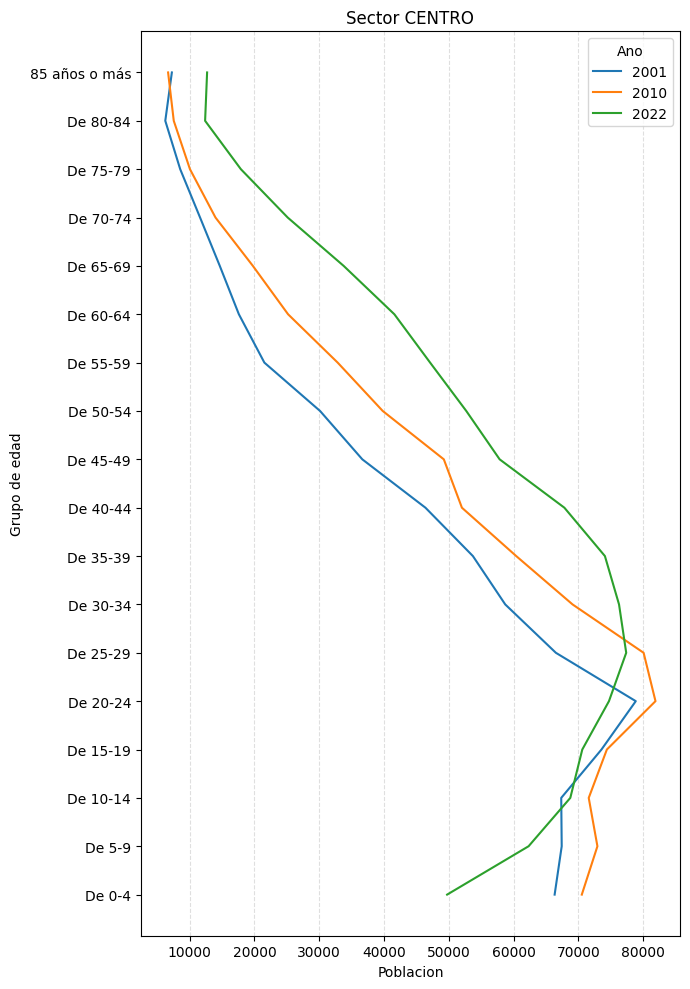

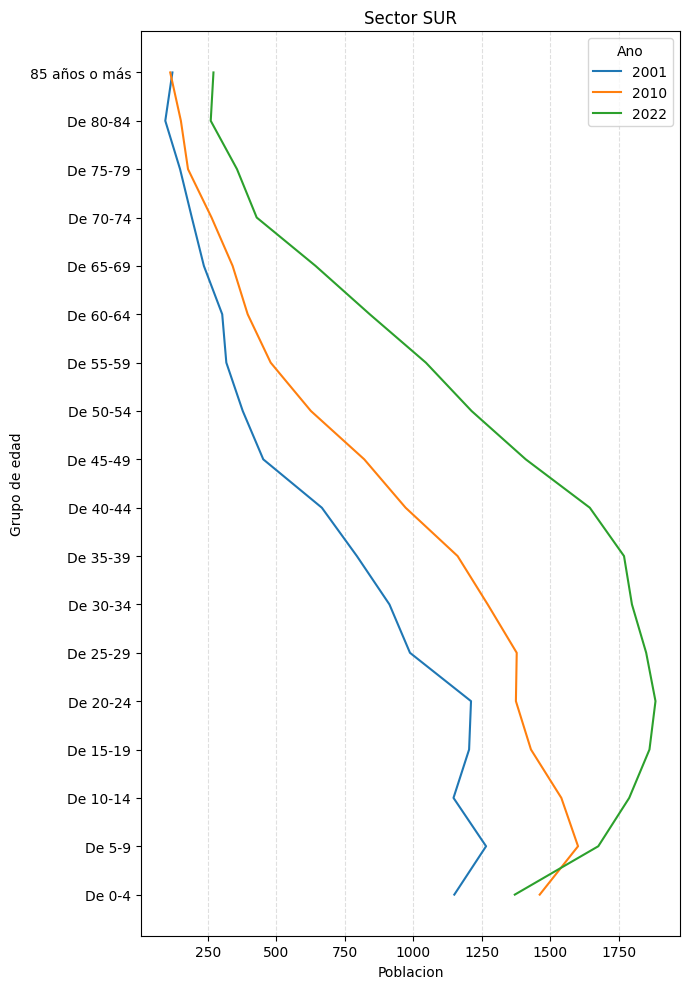

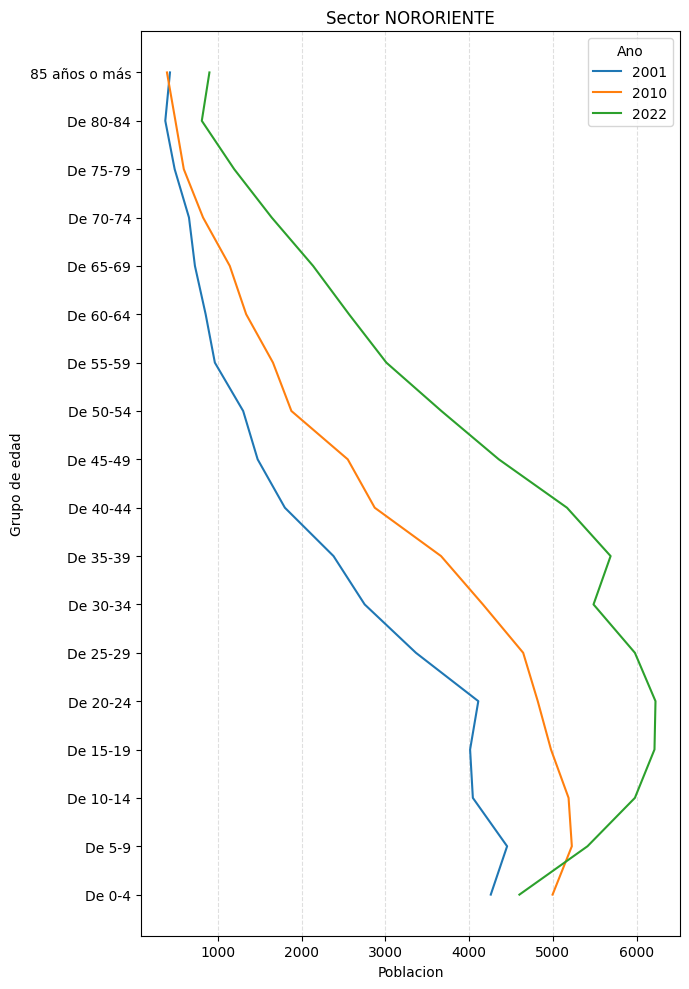

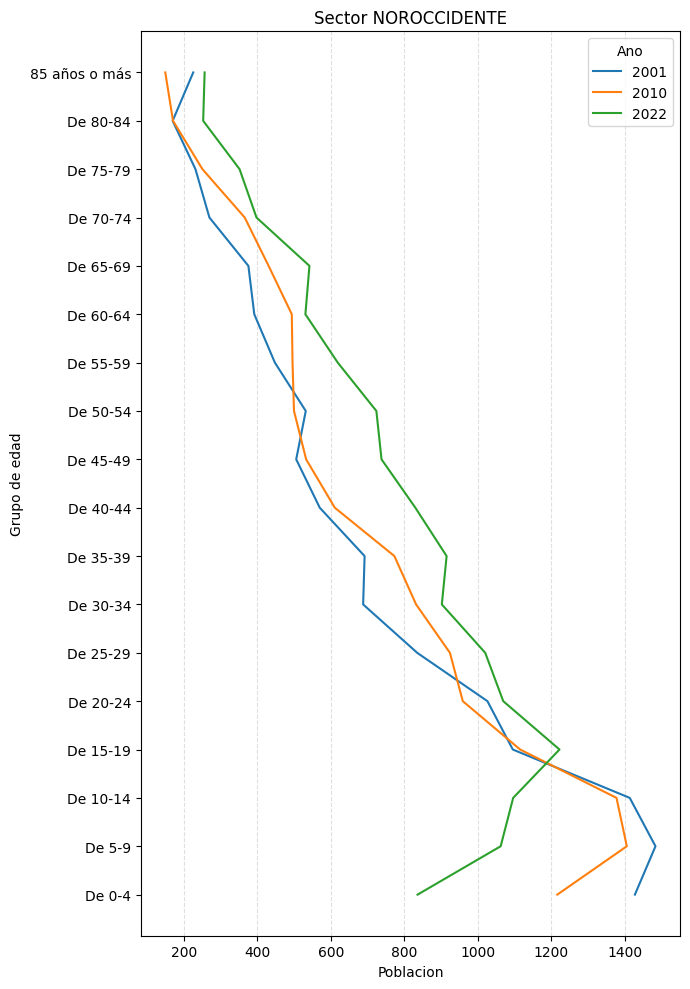

In [2]:
# Graficos por sector (lineas por ano)
for sector in sectores_disponibles:
    datos = sector_grupo[sector_grupo["SECTOR"] == sector]
    if datos.empty:
        print(f"Sin datos para {sector}")
        continue
    serie = datos.set_index("Grupo Edad")[anios]

    fig, ax = plt.subplots(figsize=(7, 10))
    for col in anios:
        ax.plot(serie[col].values, serie.index, label=col)

    ax.set_title(f"Sector {sector}")
    ax.set_xlabel("Poblacion")
    ax.set_ylabel("Grupo de edad")
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    ax.legend(title="Ano")
    plt.tight_layout()
    plt.show()


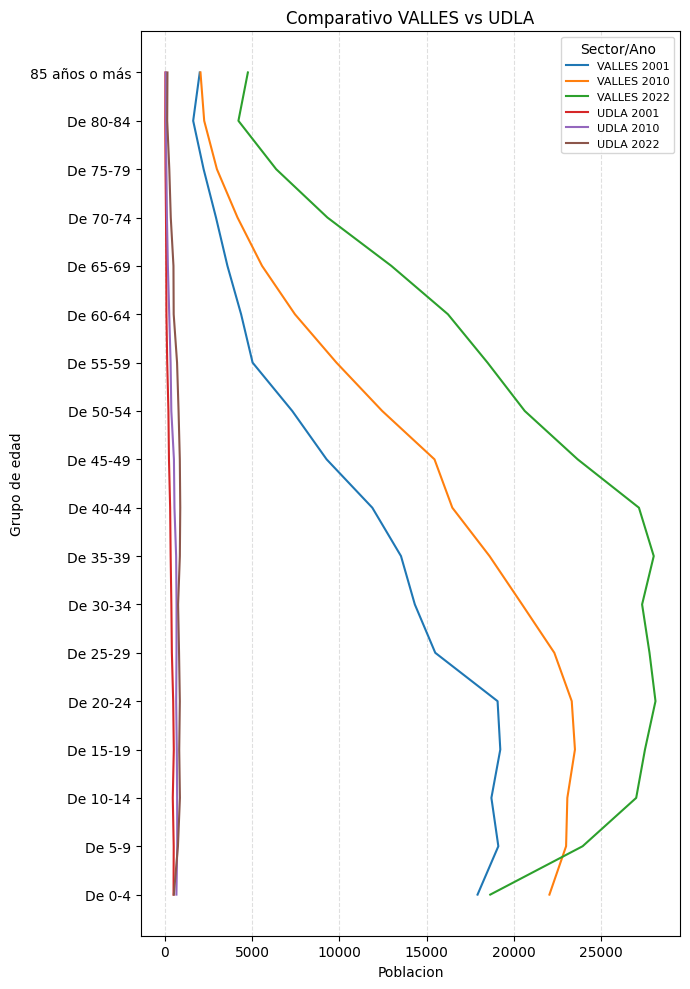

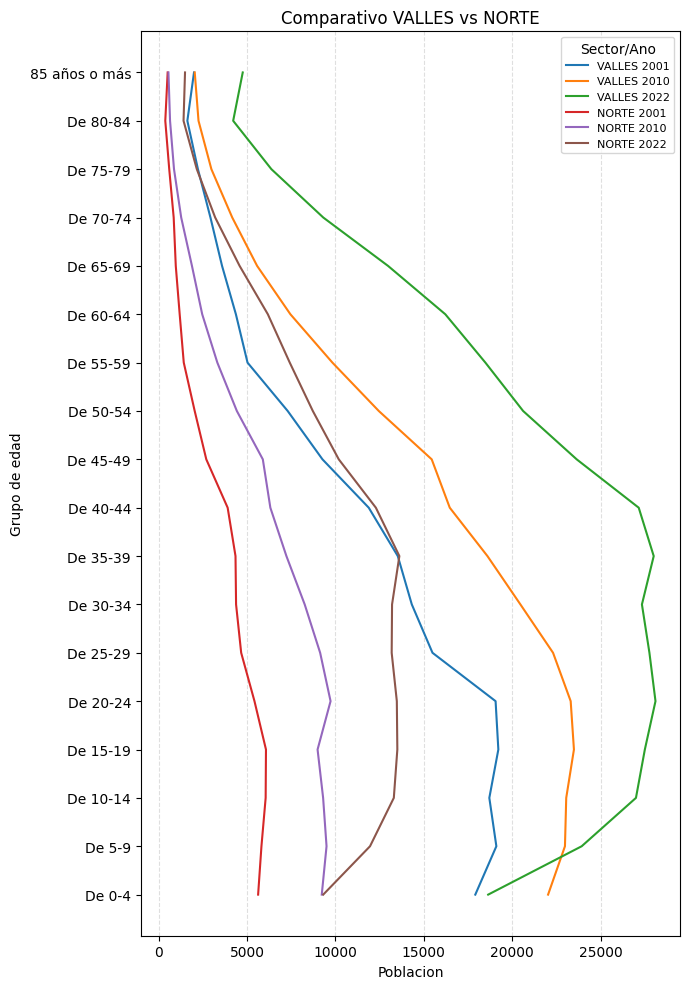

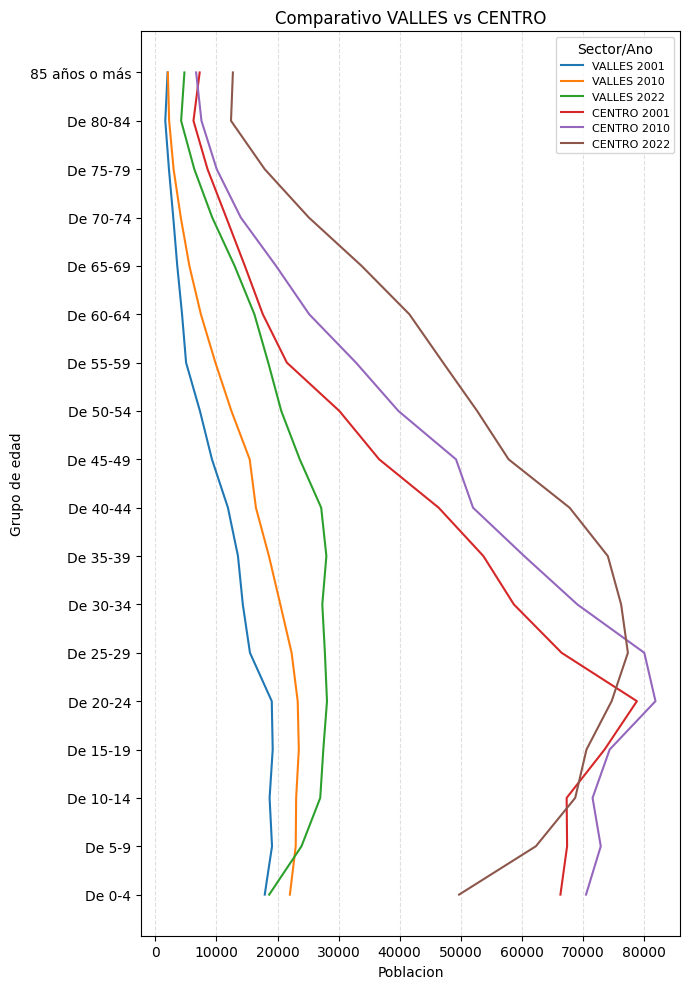

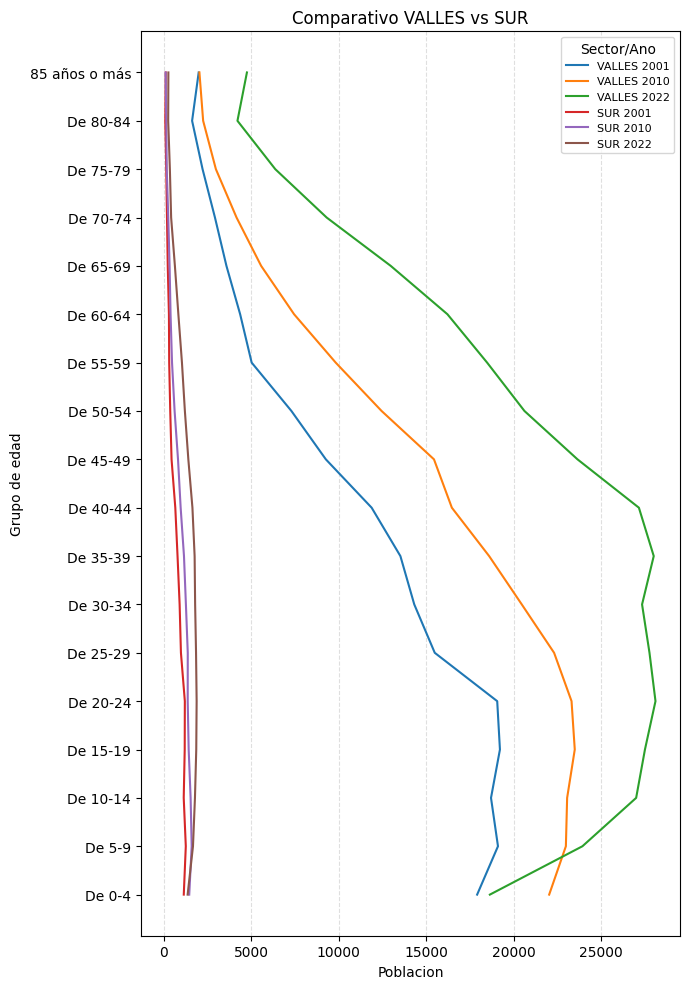

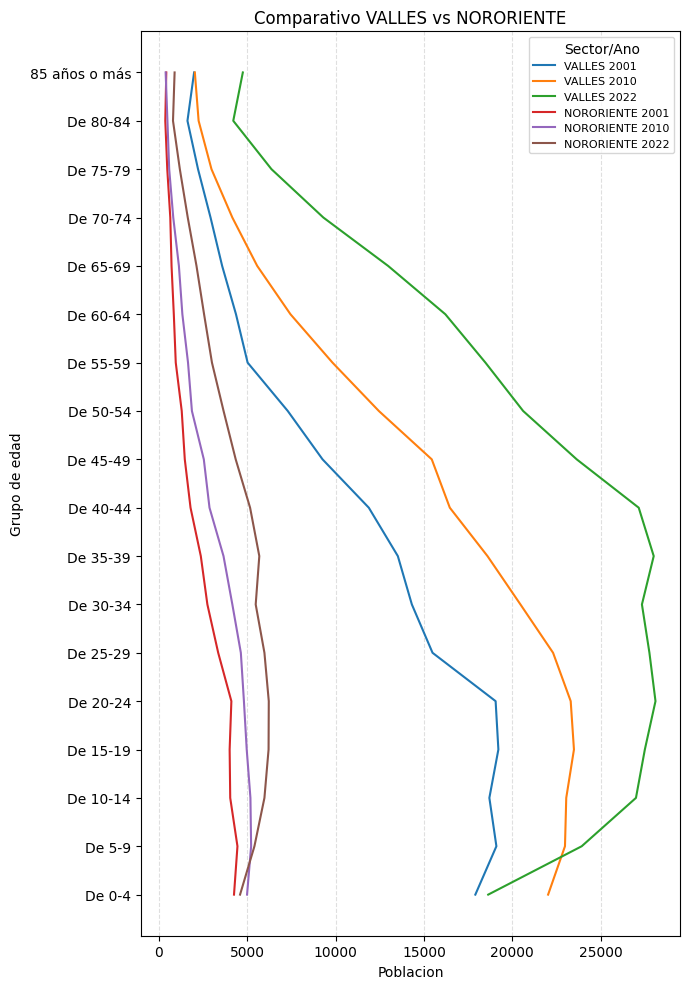

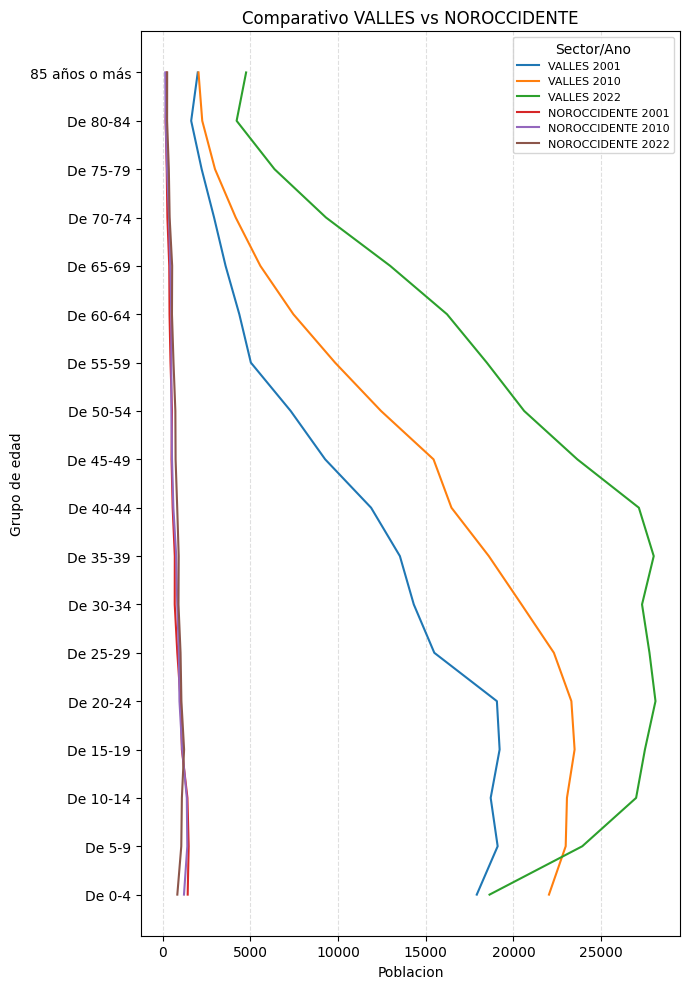

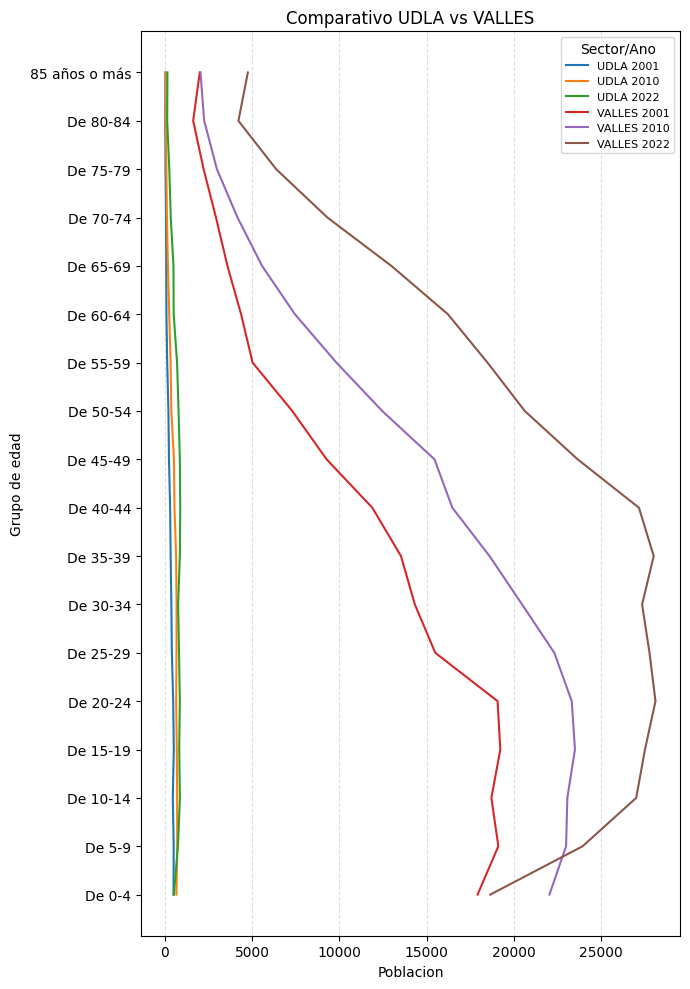

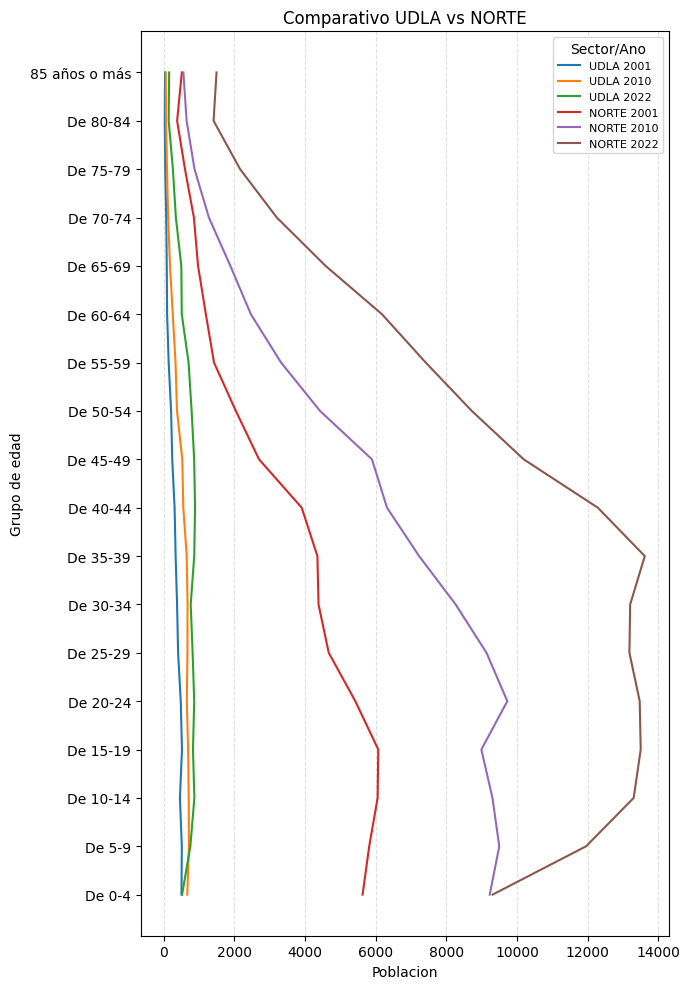

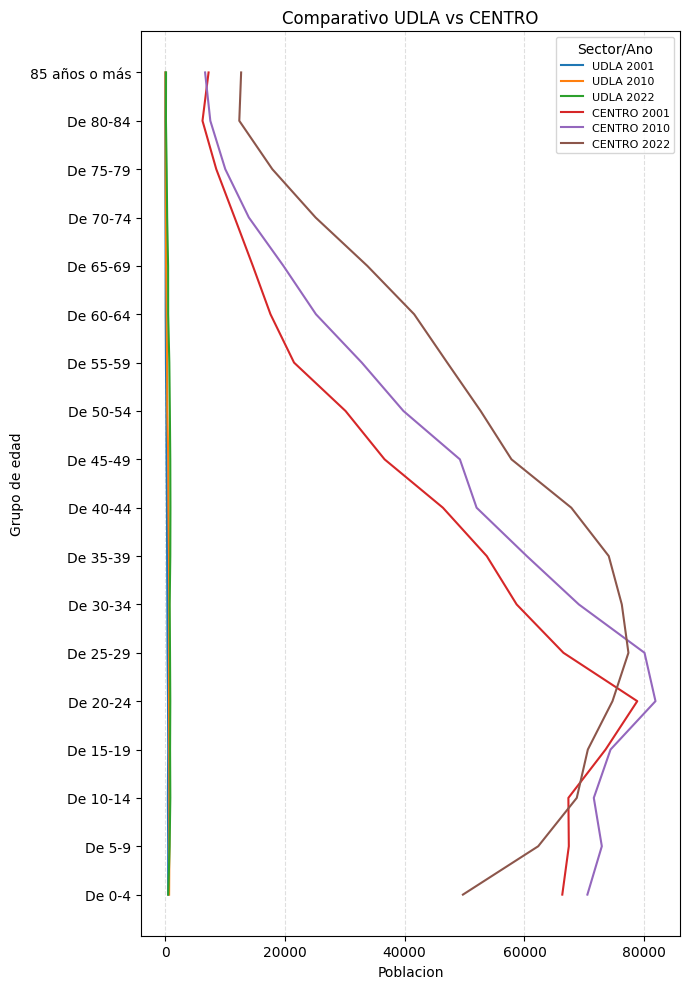

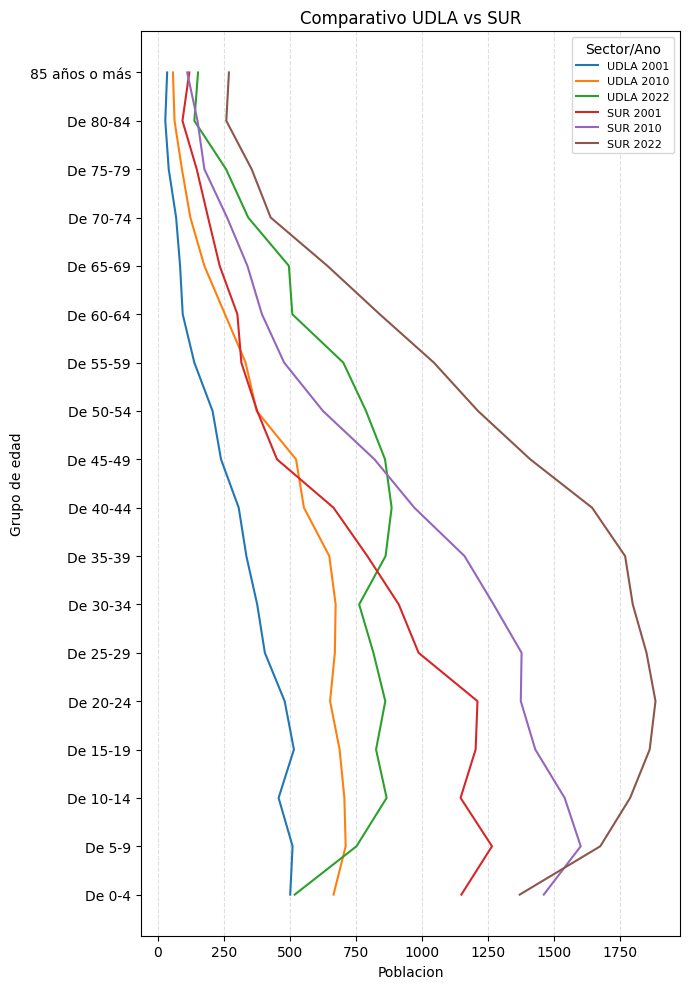

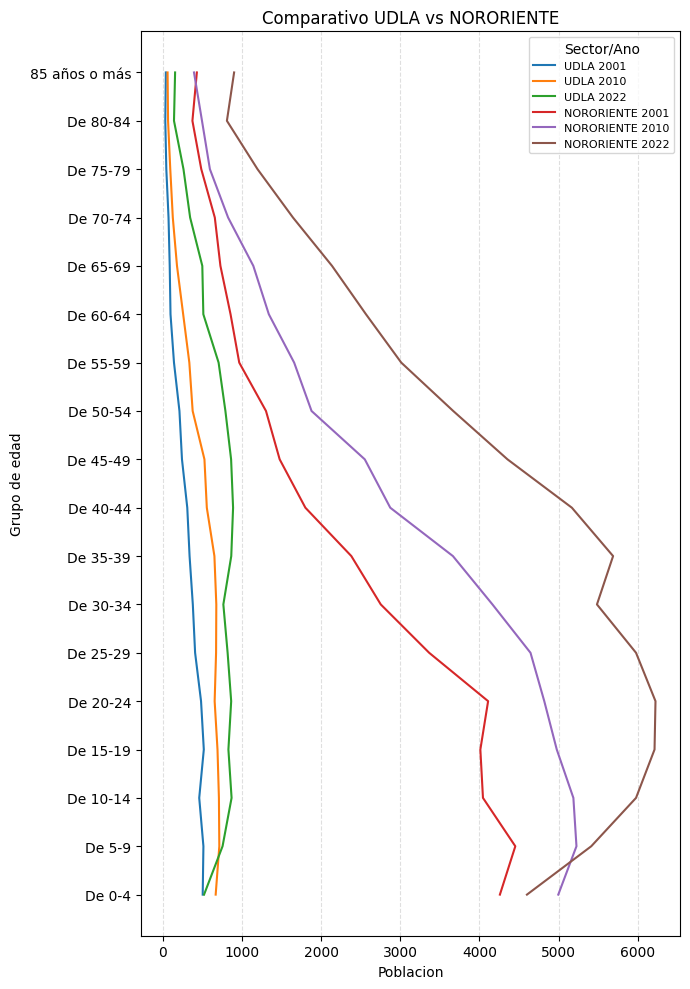

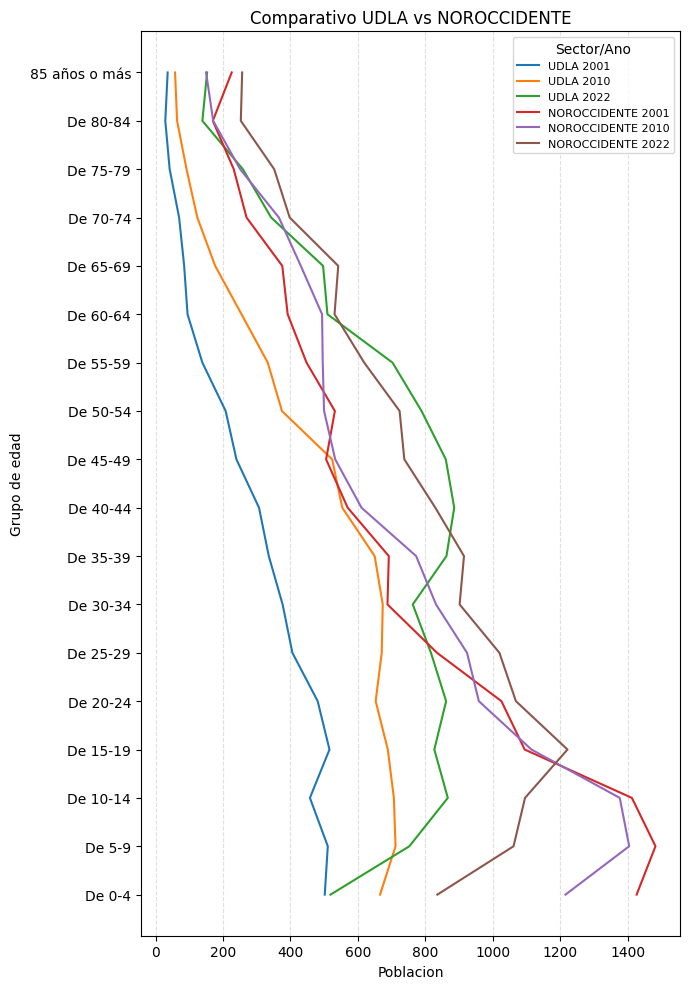

In [3]:
# Graficos comparativos: base vs cada otro sector
def graficar_comparativos(base_sector):
    sectores_comp = [s for s in sectores_disponibles if s != base_sector]
    for sector in sectores_comp:
        datos = sector_grupo[sector_grupo["SECTOR"].isin([base_sector, sector])]
        if datos.empty or datos["SECTOR"].nunique() < 2:
            print(f"Sin datos suficientes para {base_sector} vs {sector}")
            continue

        serie = datos.set_index(["SECTOR", "Grupo Edad"])[anios]
        fig, ax = plt.subplots(figsize=(7, 10))

        for s in [base_sector, sector]:
            for col in anios:
                valores = serie.loc[s][col].values
                ax.plot(valores, serie.loc[s].index, label=f"{s} {col}")

        ax.set_title(f"Comparativo {base_sector} vs {sector}")
        ax.set_xlabel("Poblacion")
        ax.set_ylabel("Grupo de edad")
        ax.grid(axis="x", linestyle="--", alpha=0.4)
        ax.legend(title="Sector/Ano", fontsize=8)
        plt.tight_layout()
        plt.show()

# Replica del patron original usando el sector base principal y uno adicional clave.
for base in ["VALLES", "UDLA"]:
    if base in sectores_disponibles:
        graficar_comparativos(base)
